# Scurve fitting in aare and comparison with M3 calibration

In [1]:
#add the dev version of aare
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

import aare
from aare import CtbRawFile, RawMasterFile, File, RawFile, RawSubFile, DetectorType
from aare.transform import matterhorn02
from aare import fit_scurve, fit_scurve2


#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from rich.console import Console
from rich.table import Table


# scurve - fit_scurve - lower counts at higher threshold [DAC]
# scurve2 - fit_scurve2 - higher counts at higher threshold [DAC]


Example run on: **2025-05-06 14:00** with aare: **dev**

## Models

### scurve - higher counts at higher threshold in DAC

Formula
$$
f(x) = p_0+p_1x+\frac{1}{2}\left(1+Erf\left(\frac{x-\mu}{\sqrt{2}\sigma}\right)\right)\left(A+c(x-\mu)\right)
$$



Implementation in C++
```c++
//p0 = background
//p1 = slope
//p2 = mu
//p3 = sigma
//p4 = ampl
//p5 = charge sharing
double scurve(const double x, const double *par) {
    return (par[0] + par[1] * x) +
           0.5 * (1 + erf((x - par[2]) / (sqrt(2) * par[3]))) *
               (par[4] + par[5] * (x - par[2]));
}
```

### scurve2 - lower counts at higher threshold in DAC

*Here only the sign changes, we could think about rewriting the eq to match parameters*

Formula
$$
f(x) = p_0+p_1x+\frac{1}{2}\left(1-Erf\left(\frac{x-\mu}{\sqrt{2}\sigma}\right)\right)\left(A+c(x-\mu)\right)
$$



Implementation in C++
```c++
//p0 = background
//p1 = slope
//p2 = mu
//p3 = sigma
//p4 = ampl
//p5 = charge sharing
double scurve(const double x, const double *par) {
    return (par[0] + par[1] * x) +
           0.5 * (1 - erf((x - par[2]) / (sqrt(2) * par[3]))) *
               (par[4] + par[5] * (x - par[2]));
}
```

### mythen3_tools

Formula - assuming sign True --> s=1
$$
f(x) = \frac{1}{2}A\left(1+Erf\left(\frac{\mu-x}{\sqrt{2}\sigma}\right)\right)\left(1+c(\mu-x)\right)+p_0-p_1x
$$

Python implementation
```python
#A = amplitude
#mu = flex
#sigma = noise
#c = chargesharing
#p0 = pedestal
#p1 = pedslope
def scurve(th, pedestal, pedslope, flex, noise, amplitude, chargesharing):
    """scurve implementation from mythen3_tools"""
    sign=True
    if sign:
        s=1
    else:
        s=-1
    y=0.5*amplitude*(1+erf(s*(flex-th)/(noise*np.sqrt(2))))*(1+chargesharing*(flex-th))+pedestal-pedslope*th*s
    return y
```

## Load some m3 data

In [2]:
path = Path('/mnt/sls_det_storage/mythen_data/Mythen3_module/trimMaxIV_20250319/standard/defaultGain/')
fpath = path/Path('standard_defaultGain_11200eV_200V_100ms_TB0_c0_master_0.json')

th = np.arange(1500,899,-5)
cut = 100 #original dataset has 121 points we cut out the 20 first to avoid dealing with the noise peak

with RawFile(fpath) as f:
    headers, data = f.read()
    data = data[:cut,:,:]
    th = th[:cut]

print(data.shape, th.shape)

# assuming bad channels are masked so we use a very low th
bad_channels = data.sum(axis = 0) < 100
bad = bad_channels[0,:]
good =  np.bitwise_not(bad)
print(f'Masked: {bad_channels.sum()} channels')

(100, 1, 1280) (100,)
Masked: 438 channels


## Load the reference data from the m3 trimming

In [3]:
#Load the reference 
reference = np.zeros((1280,5))
with open(path/'thrdisp_standard_defaultGain_11200eV_200V_100ms_TB0_c0_d0_0.dat') as f:
    for line in f:
        if not line.startswith('#'):
            chan, flex, noise, ampl, cs, counts = line.split()
            chan = int(float(chan))
            reference[chan] = np.array((float(flex), float(noise), float(ampl), float(cs), float(counts)))

## Fit all channels
- reshape data to have th as fast changing index
- no option to mask channels for fit at the moment

In [4]:
y = np.swapaxes(data, 0,2) #We need the last dimension to be different th, keeping it 3D allows for multiple counters
print(f'{y.shape=}')

t0 = time.perf_counter()
res = fit_scurve2(th, y, n_threads = 32)
t = time.perf_counter()-t0
print(f'Fit took: {t*1e3:.1f} ms')

mu_aare = res[:,0,2]
mu_m3 = reference[:,0]
channels = np.arange(0,1280,1)

y.shape=(1280, 1, 100)
Fit took: 36.5 ms


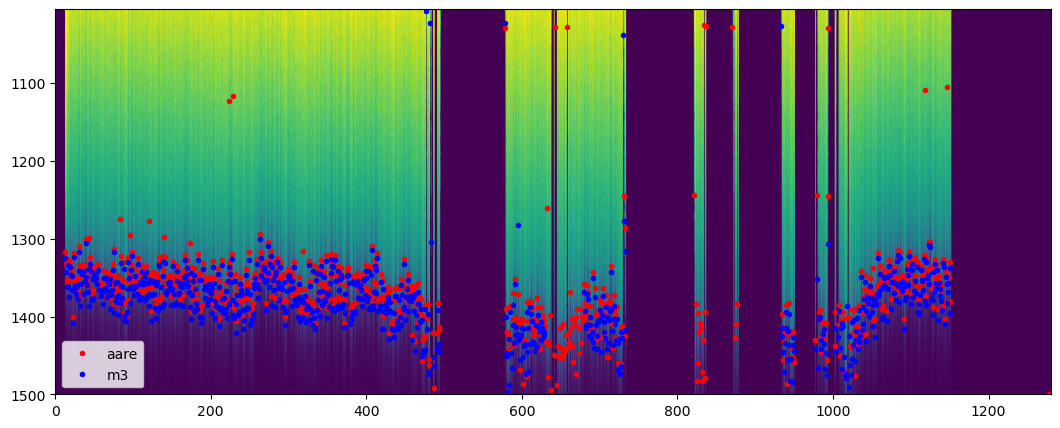

In [5]:
#plot scurves and inflection point
fig, ax = plt.subplots(figsize = (15,5))
im = ax.imshow(data[:,0,:], extent = [0,1280,th[-1],th[0]])
im.set_clim(0,5000)
ax.plot(channels[good], mu_aare[good], '.',color = 'red', label = 'aare')
ax.plot(channels[good], mu_m3[good], '.',color = 'blue', label = 'm3')
ax.set_ylim(th[0], th[-1])
ax.legend()

(array([  43,   83,   96,  121,  140,  173,  318,  582,  595,  726,  730,
         980,  981,  990,  993,  994, 1012, 1015, 1017, 1018, 1024]),)

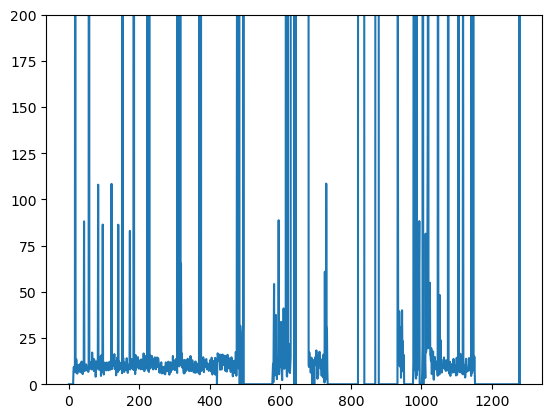

In [6]:
#Look at the difference between the fits
diff = np.abs(mu_aare-mu_m3)
diff[bad] = 0

fig, ax = plt.subplots()
ax.plot(diff)
ax.set_ylim(0,200)
np.where((diff > 50) & (diff < 200) )

           Channel: 400            
┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Parameter ┃     aare ┃       m3 ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│        p0 │ 1976.017 │    0.000 │
│        p1 │   -1.294 │    0.000 │
│        mu │ 1340.946 │ 1349.948 │
│     sigma │   43.250 │   49.259 │
│         A │ 2090.070 │ 2243.857 │
│         c │   -5.307 │    0.003 │
└───────────┴──────────┴──────────┘

Text(0.5, 1.0, 'Channel: 400')

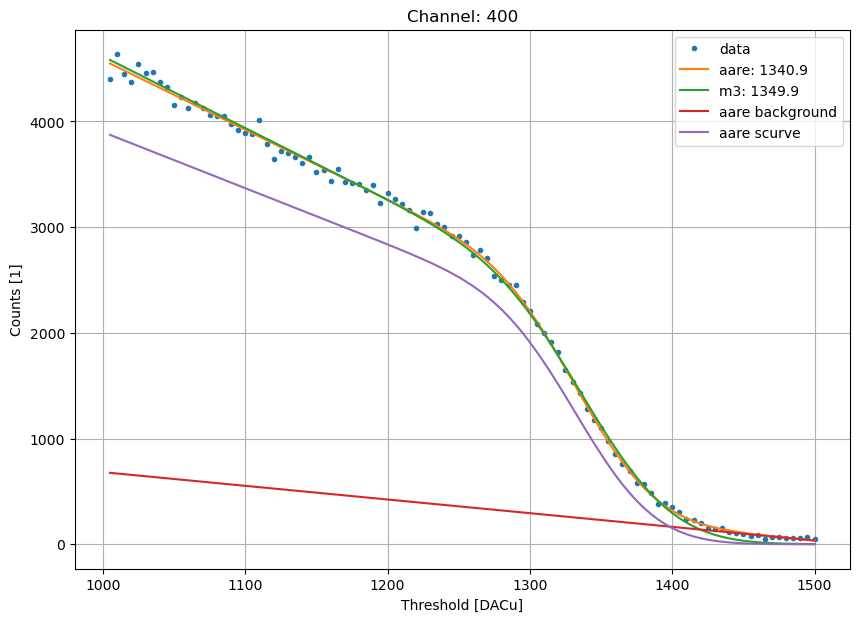

In [8]:
from scipy.special import erf
def scurve(th, pedestal, pedslope, flex, noise, amplitude, chargesharing):
    """scurve implementation from mythen3_tools"""
    sign=True
    if sign:
        s=1
    else:
        s=-1
    y=0.5*amplitude*(1+erf(s*(flex-th)/(noise*np.sqrt(2))))*(1+chargesharing*(flex-th))+pedestal-pedslope*th*s
    return y
    

channel = 400

par = np.zeros(6)
par[2:] = reference[channel, 0:4]
par_aare = res[channel,0].copy()

table = Table(title=f"Channel: {channel}")

table.add_column("Parameter", justify="right", style="cyan", no_wrap=True)
table.add_column("aare", justify="right", style="magenta")
table.add_column("m3", justify="right", style="green")

par_names = ['p0', 'p1', 'mu', 'sigma', 'A', 'c']
for i,n in enumerate(par_names):
    table.add_row(n, f'{res[channel, 0, i]:.3f}', f'{par[i]:.3f}')


console = Console()
console.print(table)


fig, ax = plt.subplots(figsize = (10,7))
ax.plot(th, data[:, 0, channel], '.', label = 'data')
ax.plot(th, aare.func.scurve2(th, par_aare), label = f'aare: {res[channel,0,2]:.1f}')
ax.plot(th, scurve(th, *par), label = f'm3: {par[2]:.1f}')

ax.plot(th, aare.func.pol1(th, par_aare[0:2][::-1]), label = 'aare background')
par_aare[0:2] = 0
ax.plot(th, aare.func.scurve2(th, par_aare), label = 'aare scurve')

ax.grid()
ax.legend()
ax.set_xlabel('Threshold [DACu]')
ax.set_ylabel('Counts [1]')
ax.set_title(f'Channel: {channel}')